# Exploratory Data Analysis (Crypto Volatility)
## In this notebook, exploring cryptocurrency OHLCV data, compute returns/volatility,
## and generate insights for modelling. Dataset: Kaggle - Cryptocurrency Historical Prices.


In [50]:
# -------------------------------------------------------
# FINAL UNIVERSAL PATH SETUP (Works in Jupyter + Script)
# -------------------------------------------------------
from pathlib import Path
import sys

try:
    # When running as a .py script
    FILE_PATH = Path(__file__).resolve()
    PROJECT_ROOT = FILE_PATH.parents[2]  # crypto-volatility-ml
except NameError:
    # When running inside Jupyter Notebook
    PROJECT_ROOT = Path.cwd().resolve().parents[0]  # crypto-volatility-ml

DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"

# Create directories if missing
RAW_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Allow imports from src/
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

print("PROJECT_ROOT:", PROJECT_ROOT)
print("RAW_DIR:", RAW_DIR)
print("PROCESSED_DIR:", PROCESSED_DIR)


PROJECT_ROOT: C:\Users\BALA\OneDrive - University of Hertfordshire\Desktop\Hemanth Project\crypto-volatility-ml
RAW_DIR: C:\Users\BALA\OneDrive - University of Hertfordshire\Desktop\Hemanth Project\crypto-volatility-ml\data\raw
PROCESSED_DIR: C:\Users\BALA\OneDrive - University of Hertfordshire\Desktop\Hemanth Project\crypto-volatility-ml\data\processed


In [51]:
# === combine_all_raw_csvs.py ===
# Works whether this file is in data/raw/ or run from a notebook

import sys
import re
import pandas as pd
import numpy as np
from pathlib import Path

# -------------------------------------------------------
# 1. FINAL UNIVERSAL PATH SETUP (Jupyter + Script)
# -------------------------------------------------------
try:
    FILE_PATH = Path(__file__).resolve()
    PROJECT_ROOT = FILE_PATH.parents[2]  # crypto-volatility-ml
except NameError:
    PROJECT_ROOT = Path.cwd().resolve().parents[0]  # crypto-volatility-ml

DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"

RAW_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Ensure src is importable
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

print("PROJECT_ROOT:", PROJECT_ROOT)
print("RAW_DIR:", RAW_DIR)
print("PROCESSED_DIR:", PROCESSED_DIR)

COMBINED_CSV = RAW_DIR / "crypto_all_combined.csv"


# -------------------------------------------------------
# Helpers
# -------------------------------------------------------
def _normalise_cols(df):
    df.columns = [
        re.sub(r"[^a-z0-9_]+", "", c.strip().lower().replace(" ", "_"))
        for c in df.columns
    ]
    return df


def _coerce_numeric(s):
    return pd.to_numeric(
        s.astype(str)
         .str.replace(",", "", regex=False)
         .str.replace("$", "", regex=False)
         .str.strip(),
        errors="coerce",
    )


# -------------------------------------------------------
# Combiner Function
# -------------------------------------------------------
def combine_all_raw_csvs(raw_dir: Path, out_csv: Path) -> Path:
    csv_files = list(raw_dir.rglob("*.csv"))
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found under: {raw_dir}")

    frames = []

    for p in csv_files:
        if p.name.endswith(".py"):
            continue  # don't read this script

        try:
            df = pd.read_csv(p)
        except Exception:
            df = pd.read_csv(p, encoding="latin-1")

        df = _normalise_cols(df)

        required = [
            "date", "open", "high", "low", "close", "volume",
            "marketcap", "name", "symbol"
        ]

        for col in required:
            if col not in df.columns:
                df[col] = np.nan

        # numeric conversion
        for c in ["open", "high", "low", "close", "volume", "marketcap"]:
            df[c] = _coerce_numeric(df[c])

        # infer coin name from filename
        if df["name"].isna().all() or (df["name"].astype(str).str.strip() == "").all():
            name = re.sub(r"^coin[_\-]", "", p.stem, flags=re.I)
            df["name"] = name.replace("_", " ").replace("-", " ").title()

        try:
            source = str(p.relative_to(raw_dir))
        except ValueError:
            source = p.name

        keep = df[required].copy()
        keep["source_file"] = source
        keep = keep.dropna(subset=["date"])

        frames.append(keep)

    combined = pd.concat(frames, ignore_index=True)
    combined = combined.drop_duplicates(subset=["name", "date"])
    combined = combined.sort_values(["name", "date"]).reset_index(drop=True)

    combined = combined.rename(
        columns={
            "date": "Date",
            "open": "Open",
            "high": "High",
            "low": "Low",
            "close": "Close",
            "volume": "Volume",
            "marketcap": "MarketCap",
            "name": "Name",
            "symbol": "Symbol",
            "source_file": "SourceFile",
        }
    )

    if "MarketCap" in combined.columns and combined["MarketCap"].isna().all():
        combined = combined.drop(columns=["MarketCap"])
        print("Dropped MarketCap (all NaN)")

    final_cols = [
        "Date", "Open", "High", "Low", "Close",
        "Volume", "Name", "Symbol", "SourceFile"
    ]
    combined = combined[final_cols]

    combined.to_csv(out_csv, index=False)
    print(f"\nSaved combined dataset: {out_csv}")

    return out_csv


# -------------------------------------------------------
# Run Combiner
# -------------------------------------------------------
if not COMBINED_CSV.exists():
    print(f"Combining CSVs from: {RAW_DIR}")
    combine_all_raw_csvs(RAW_DIR, COMBINED_CSV)
else:
    print(f"Using existing combined CSV: {COMBINED_CSV}")


# -------------------------------------------------------
# Load Data
# -------------------------------------------------------
df = (
    pd.read_csv(COMBINED_CSV, parse_dates=["Date"])
    .sort_values(["Name", "Date"])
    .reset_index(drop=True)
)

top_coins = ["Bitcoin", "Ethereum", "Ripple", "Litecoin"]
df = df[df["Name"].isin(top_coins)]

print(df.head())


from src.data.features import compute_features
from src.data.clean import clean_and_scale
from src.data.split import time_series_split

features_df = compute_features(df)

feature_cols = [
    "LogReturn", "Volatility_7d", "Volatility_30d",
    "Momentum_7d", "Momentum_30d",
    "Close_lag1", "Close_lag7", "Close_lag30",
    "Volume_lag1", "Volume_lag7", "Volume_lag30",
    "Bollinger_Width", "DayOfWeek", "Month"
]
target_col = "Close"

processed_df, scaler = clean_and_scale(features_df, feature_cols, target_col)

train_df, test_df = time_series_split(processed_df, test_size=0.2)

OUT_FILE = PROCESSED_DIR / "crypto_features.csv"
processed_df.to_csv(OUT_FILE, index=False)

print("\nSaved processed dataset:", OUT_FILE)
print("Train:", train_df.shape, " Test:", test_df.shape)


PROJECT_ROOT: C:\Users\BALA\OneDrive - University of Hertfordshire\Desktop\Hemanth Project\crypto-volatility-ml
RAW_DIR: C:\Users\BALA\OneDrive - University of Hertfordshire\Desktop\Hemanth Project\crypto-volatility-ml\data\raw
PROCESSED_DIR: C:\Users\BALA\OneDrive - University of Hertfordshire\Desktop\Hemanth Project\crypto-volatility-ml\data\processed
Using existing combined CSV: C:\Users\BALA\OneDrive - University of Hertfordshire\Desktop\Hemanth Project\crypto-volatility-ml\data\raw\crypto_all_combined.csv
                    Date        Open        High         Low       Close  \
1717 2013-04-29 23:59:59  134.444000  147.488007  134.000000  144.539993   
1718 2013-04-30 23:59:59  144.000000  146.929993  134.050003  139.000000   
1719 2013-05-01 23:59:59  139.000000  139.889999  107.720001  116.989998   
1720 2013-05-02 23:59:59  116.379997  125.599998   92.281898  105.209999   
1721 2013-05-03 23:59:59  106.250000  108.127998   79.099998   97.750000   

      Volume     Name Symbo

In [40]:
# === Importing necessary libraries ===
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# === Loading Data ===
data_path = Path("../data/raw/crypto_all_combined.csv") 
df = pd.read_csv(data_path)

print(df.head())
print(df.info())

# Checking total missing values per column
print(df.isnull().sum())


                  Date       Open       High        Low      Close  \
0  2020-10-05 23:59:59  52.675035  55.112358  49.787900  53.219243   
1  2020-10-06 23:59:59  53.291969  53.402270  40.734578  42.401599   
2  2020-10-07 23:59:59  42.399947  42.408314  35.970690  40.083976   
3  2020-10-08 23:59:59  39.885262  44.902511  36.696057  43.764463   
4  2020-10-09 23:59:59  43.764463  47.569533  43.291776  46.817744   

         Volume  Name Symbol     SourceFile  
0  0.000000e+00  Aave   AAVE  coin_Aave.csv  
1  5.830915e+05  Aave   AAVE  coin_Aave.csv  
2  6.828342e+05  Aave   AAVE  coin_Aave.csv  
3  1.658817e+06  Aave   AAVE  coin_Aave.csv  
4  8.155377e+05  Aave   AAVE  coin_Aave.csv  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37082 entries, 0 to 37081
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        37082 non-null  object 
 1   Open        37082 non-null  float64
 2   High        37082 non-null

In [41]:
# === Basic Cleaning ===
# Ensure Date is datetime and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Name','Date'])

# Focusing on top 4 coins for now (BTC, ETH, LTC)
top_coins = ['Bitcoin', 'Ethereum', 'Litecoin']
df = df[df['Name'].isin(top_coins)]


In [42]:
# === Computing Returns ===

# Computing log returns and volatility
df['LogReturn'] = df.groupby('Name')['Close'].transform(lambda x: np.log(x).diff())
df['Volatility_7d'] = df.groupby('Name')['LogReturn'].transform(lambda x: x.rolling(7).std())
df['Volatility_30d'] = df.groupby('Name')['LogReturn'].transform(lambda x: x.rolling(30).std())

df[df['Name']=='Bitcoin'][['Date', 'Close', 'LogReturn', 'Volatility_7d', 'Volatility_30d']].head(40)

# Summary statistics
summary = df.groupby("Name")[["Close", "LogReturn", "Volatility_30d"]].describe().round(4)
display(summary)


Close                                                       \
           count       mean         std      min       25%        50%   
Name                                                                    
Bitcoin   2991.0  6711.2904  11298.1419  68.4310  430.5695  2286.4099   
Ethereum  2160.0   383.9107    601.0788   0.4348   13.8192   198.6437   
Litecoin  2991.0    49.2790     63.2405   1.1570    3.7941    29.9002   

                                LogReturn          ...                  \
                75%         max     count    mean  ...     75%     max   
Name                                               ...                   
Bitcoin   8576.2387  63503.4579    2990.0  0.0018  ...  0.0185  0.3575   
Ethereum   386.4353   4168.7010    2159.0  0.0037  ...  0.0297  0.4103   
Litecoin    62.0250    386.4508    2990.0  0.0012  ...  0.0213  0.8293   

         Volatility_30d                                                  \
                  count    mean     std     min     25%     50%     75%   
Name                                                                      
Bitcoin          2961.0  0.0375  0.0196  0.0071  0.0248  0.0337  0.0466   
Ethereum         2130.0  0.0554  0.0237  0.0183  0.0369  0.0500  0.0678   
Litecoin         2961.0  0.0538  0.0336  0.0073  0.0318  0.0463  0.0645   

                  
             max  
Name              
Bitcoin   0.1298  
Ethereum  0.1343  
Litecoin  0.2474  

[3 rows x 24 columns]

Saved interactive plot: ..\reports\figures\rolling_volatility.html


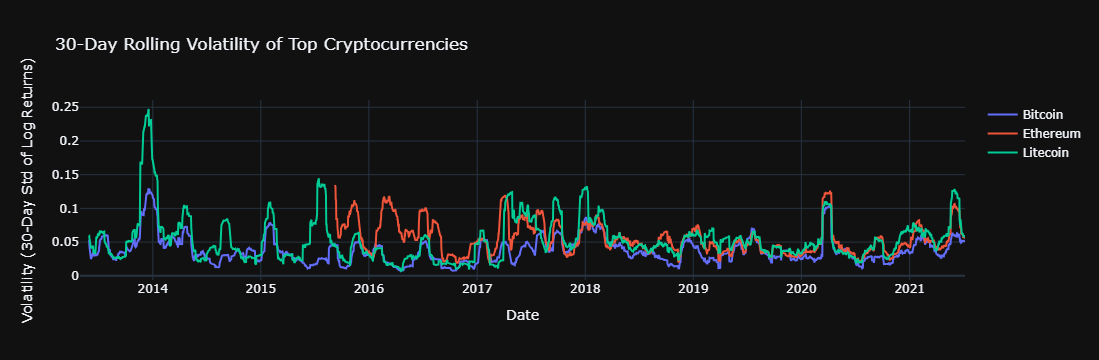

In [43]:
# === Rolling Volatility ===
import plotly.graph_objects as go
fig_dir = Path("../reports/figures")

fig = go.Figure()
for coin in top_coins:
    coin_df = df[df["Name"] == coin]
    fig.add_trace(go.Scatter(
        x=coin_df["Date"],
        y=coin_df["Volatility_30d"],
        mode="lines",
        name=coin
    ))

fig.update_layout(
    title="30-Day Rolling Volatility of Top Cryptocurrencies",
    xaxis_title="Date",
    yaxis_title="Volatility (30-Day Std of Log Returns)",
    template="plotly_dark"
)

# Saving as interactive HTML
prices_path = fig_dir / "rolling_volatility.html"
fig.write_html(prices_path)   

print(f"Saved interactive plot: {prices_path}")

fig.show()


Saved interactive plot: ..\reports\figures\daily_closing_prices.html


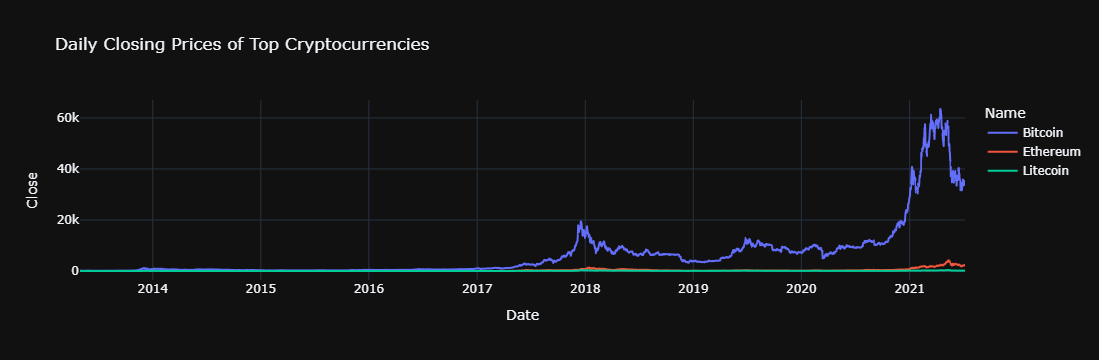

In [44]:
# === Interactive Daily Closing Prices ===
import plotly.express as px
from pathlib import Path

fig_dir.mkdir(parents=True, exist_ok=True)

fig = px.line(
    df,
    x="Date", y="Close", color="Name",
    title="Daily Closing Prices of Top Cryptocurrencies",
    template="plotly_dark"
)

# Saving as interactive HTML
prices_path = fig_dir / "daily_closing_prices.html"
fig.write_html(prices_path)

print(f"Saved interactive plot: {prices_path}")

fig.show()


Saved static plot: ..\reports\figures\bitcoin_logreturn_distribution.png


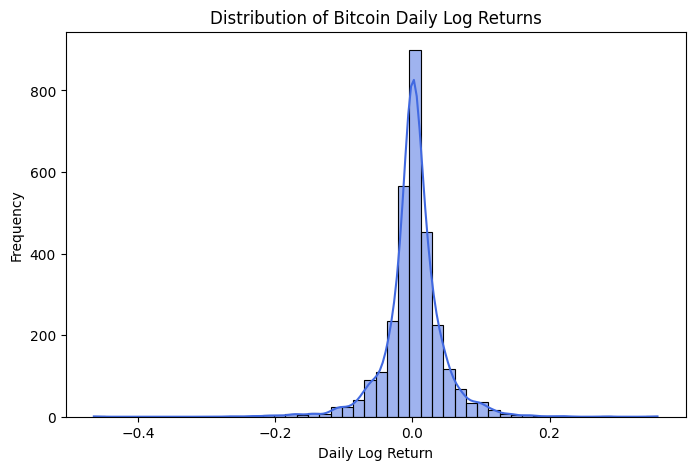

In [45]:
# === Plotting Returns Distribution ===
# Plotting histogram
plt.figure(figsize=(8, 5))
sns.histplot(
    df[df['Name'] == "Bitcoin"]['LogReturn'].dropna(),
    bins=50, kde=True, color='royalblue'
)
plt.title("Distribution of Bitcoin Daily Log Returns")
plt.xlabel("Daily Log Return")
plt.ylabel("Frequency")

# Saving image before showing
save_path = fig_dir / "bitcoin_logreturn_distribution.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved static plot: {save_path}")

plt.show()

Saved static plot: ..\reports\figures\Correlation_of_Daily_Log_Returns.png


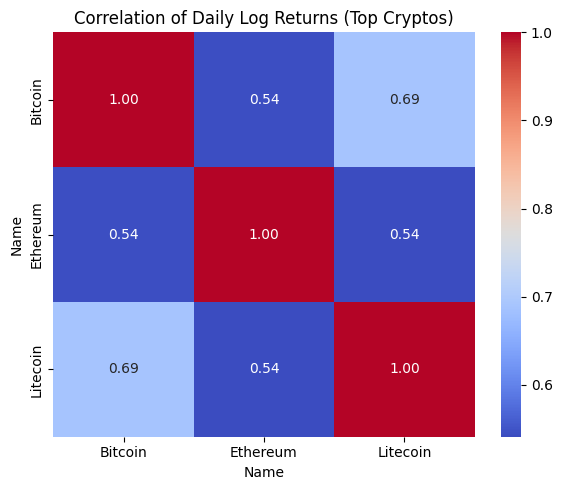

In [46]:
# === Plotting Correlation Heatmap ===

returns_pivot = df.pivot(index="Date", columns="Name", values="LogReturn")
corr = returns_pivot.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Daily Log Returns (Top Cryptos)")
plt.tight_layout()

# Saving image before showing
save_path = fig_dir / "Correlation_of_Daily_Log_Returns.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved static plot: {save_path}")

plt.show()


Saved interactive plot: ..\reports\figures\price_vs_volatility_dual_axis.html


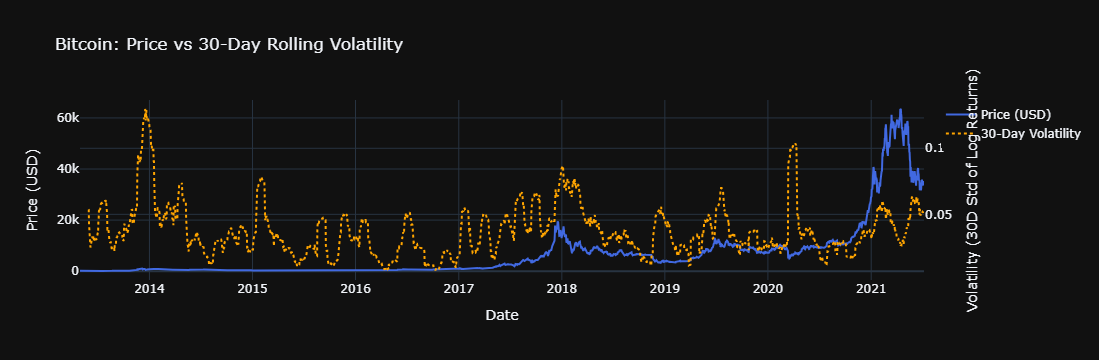

In [47]:
# === Price vs Volatility Dual-Axis (for Bitcoin) ===
import plotly.graph_objects as go

coin = "Bitcoin"
coin_df = df[df["Name"] == coin].copy()

fig = go.Figure()

# Primary y-axis: Price
fig.add_trace(go.Scatter(
    x=coin_df["Date"], y=coin_df["Close"],
    name="Price (USD)", line=dict(color="royalblue", width=2)
))

# Secondary y-axis: 30-day Volatility
fig.add_trace(go.Scatter(
    x=coin_df["Date"], y=coin_df["Volatility_30d"],
    name="30-Day Volatility", line=dict(color="orange", width=2, dash="dot"),
    yaxis="y2"
))

# Layout
fig.update_layout(
    title=f"{coin}: Price vs 30-Day Rolling Volatility",
    xaxis=dict(title="Date"),
    yaxis=dict(title="Price (USD)", side="left"),
    yaxis2=dict(title="Volatility (30D Std of Log Returns)", overlaying="y", side="right"),
    template="plotly_dark",
    hovermode="x unified"
)

path = fig_dir / "price_vs_volatility_dual_axis.html"
fig.write_html(path)
print(f"Saved interactive plot: {path}")
fig.show()


Saved interactive plot: ..\reports\figures\volatility_ranking_bar.html


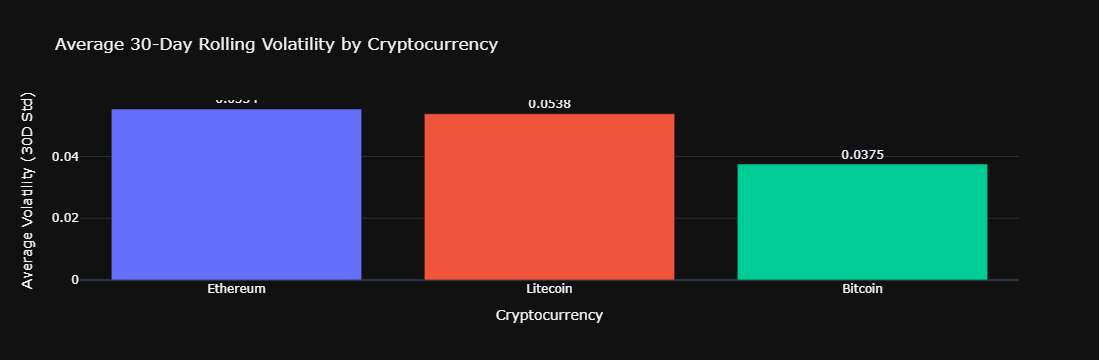

In [48]:
# === Volatility Ranking Bar Chart ===
vol_rank = (
    df.groupby("Name")["Volatility_30d"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

fig = px.bar(
    vol_rank, x="Name", y="Volatility_30d",
    color="Name",
    title="Average 30-Day Rolling Volatility by Cryptocurrency",
    text=vol_rank["Volatility_30d"].round(4),
    template="plotly_dark"
)
fig.update_traces(textposition="outside")
fig.update_layout(
    xaxis_title="Cryptocurrency",
    yaxis_title="Average Volatility (30D Std)",
    showlegend=False
)

path = fig_dir / "volatility_ranking_bar.html"
fig.write_html(path)
print(f"Saved interactive plot: {path}")
fig.show()


In [49]:
# -------------------------------------------------------
# 6. Feature Engineering Pipeline
# -------------------------------------------------------
from src.data.features import compute_features
from src.data.clean import clean_and_scale
from src.data.split import time_series_split

features_df = compute_features(df)

feature_cols = [
    "LogReturn", "Volatility_7d", "Volatility_30d",
    "Momentum_7d", "Momentum_30d",
    "Close_lag1", "Close_lag7", "Close_lag30",
    "Volume_lag1", "Volume_lag7", "Volume_lag30",
    "Bollinger_Width", "DayOfWeek", "Month"
]
target_col = "Close"

processed_df, scaler = clean_and_scale(features_df, feature_cols, target_col)

train_df, test_df = time_series_split(processed_df, test_size=0.2)

# final processed save
OUT_FILE = PROCESSED_DIR / "crypto_features.csv"
processed_df.to_csv(OUT_FILE, index=False)

print(f"\nSaved processed dataset: {OUT_FILE}")
print(f"Train: {train_df.shape}, Test: {test_df.shape}")

Starting cleaning...
Remaining missing values after fill: 0
X shape before scaling: (8142, 14)
Sample rows:
   LogReturn  Volatility_7d  Volatility_30d  Momentum_7d  Momentum_30d  \
0   0.001881       0.028475        0.033913     0.001312      0.001166   
1  -0.039082       0.028475        0.033913    -0.039082     -0.039082   
2  -0.172385       0.094260        0.094260    -0.105734     -0.105734   

    Close_lag1  Close_lag7  Close_lag30  Volume_lag1  Volume_lag7  \
0  2279.919922    2230.875  1888.650024  943800992.0  930831488.0   
1   144.539993    2230.875  1888.650024          0.0  930831488.0   
2   139.000000    2230.875  1888.650024          0.0  930831488.0   

   Volume_lag30  Bollinger_Width  DayOfWeek  Month  
0   803747008.0         0.114764          0      4  
1   803747008.0         0.055264          1      4  
2   803747008.0         0.218297          2      5  
Processed shape: (8142, 17)

Saved processed dataset: C:\Users\BALA\OneDrive - University of Hertfordshire